In [2]:
import numpy as np
import pandas as pd
import pybiomart as bm
import scanpy as sc

In [3]:
input_path_healthy = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Datasets Integration/Integrated datasets/All_cells_5000_HVGs_scvi_scanvi.h5ad'
Healthy_adata = sc.read_h5ad(input_path_healthy)

In [5]:
# Upload unprocessed dataset (before HVGs extraction)
input_path_healthy_all_counts = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Healthy_reference/GCA_Kong_Smillie_Wang_unprocessed/GCA_Kong_Wang_Smillie_raw.h5ad'
healthy_all_counts = sc.read_h5ad(input_path_healthy_all_counts)

### Preprocess X in Healthy data

In [6]:
# Transfer var and X from unprocessed dataset to processed one
healthy_all_counts.obs = Healthy_adata.obs
healthy_all_counts.obsm = Healthy_adata.obsm
healthy_all_counts.uns = Healthy_adata.uns
healthy_all_counts.obsp = Healthy_adata.obsp

In [7]:
del Healthy_adata

In [8]:
healthy_all_counts

AnnData object with n_obs × n_vars = 557099 × 23616
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels'
    var: 'gene_id-Kong', 'gene_name-Kong', 'n_cells_by_counts-Kong', 'mean_counts-Kong', 'log1p_mean_counts-Kong', 'pct_dropout_by_counts-Kong', 'total_counts-Kong', 'log1p_total_counts-Kong', 'mito-Kong', 'ribo-Kong', 'highly_variable-Kong', 'highly_variable_rank-Kong', 'means-Kong', 'variances-Kong', 'variances_norm-Kong'
    uns: 'Age_group_colors', 'Cell Type_colors', 'Diagnosis_colors', 'Donor_ID_colors', 'Gender_colors', 'Library_Preparation_Protocol_colors', 'Location_colors', 'Study_name_colors', '_scvi_manager

In [32]:
healthy_all_counts.obs['Gender'].value_counts()

Male      345664
Female    208927
nan         2508
Name: Gender, dtype: int64

In [27]:
# Filter cells with 'nan' in healthy_all_counts.obs['Sex']
missing_samples = healthy_all_counts[healthy_all_counts.obs['Gender'] == 'nan', :]

In [9]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [10]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
MT-TF,ENSG00000210049,577,647,MT
MT-RNR1,ENSG00000211459,648,1601,MT
MT-TV,ENSG00000210077,1602,1670,MT
MT-RNR2,ENSG00000210082,1671,3229,MT
MT-TL1,ENSG00000209082,3230,3304,MT


In [28]:
chrY_genes = missing_samples.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Y_RNA', 'ZFY', 'PCDH11Y', 'RPS4Y1', 'ZFY-AS1', 'LINC00278', 'USP9Y',
       'DDX3Y', 'UTY', 'TMSB4Y', 'TTTY14', 'KDM5D', 'EIF1AY', 'RPS4Y2',
       'TBL1Y', 'NLGN4Y', 'TTTY10', 'SRY', 'TTTY7', 'FAM224B', 'FAM224A',
       'AMELY'],
      dtype='object')

In [29]:
missing_samples.var_names.str.match('XIST')

array([False, False, False, ..., False, False, False])

In [30]:
chrY_sum = missing_samples[:, chrY_genes].X.sum(axis=1)
total_sum = missing_samples.X.sum(axis=1)

# Flatten the arrays and calculate percent_chrY
missing_samples.obs['percent_chrY'] = (np.asarray(chrY_sum).flatten() / np.asarray(total_sum).flatten()) * 100

/var/folders/gb/wwnzrh015q9dns5cmsc3xcjsxglkqz/T/ipykernel_4465/2083699403.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  missing_samples.obs['percent_chrY'] = (np.asarray(chrY_sum).flatten() / np.asarray(total_sum).flatten()) * 100


In [31]:
missing_samples.obs["XIST-counts"] = missing_samples.X[:, missing_samples.var_names.str.match('XIST')].toarray().squeeze()

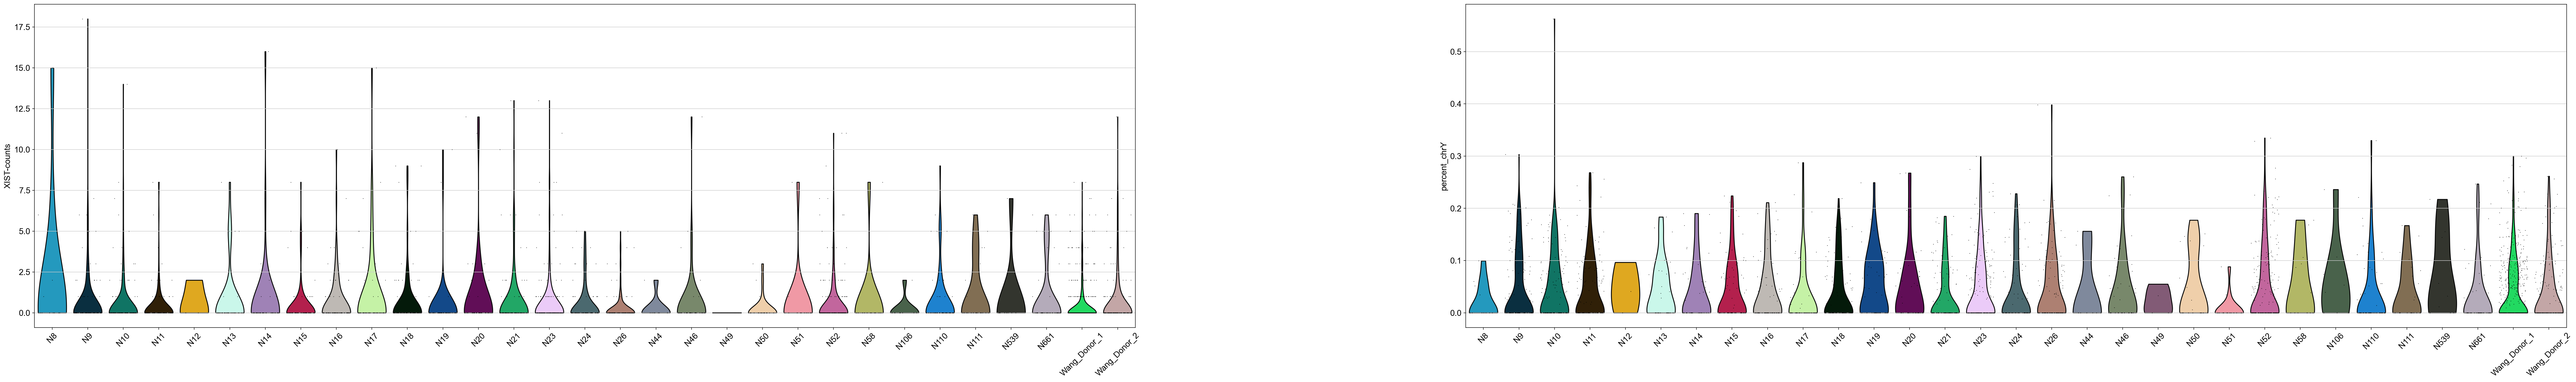

In [23]:
sc.set_figure_params(figsize=(25, 10),dpi=100)
sc.pl.violin(missing_samples, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'Donor_ID', rotation = 45)

In [60]:
missing_samples.obs['Donor_ID'].value_counts()

Wang_Donor_1    505
N52             224
N23             199
Wang_Donor_2    155
N10             143
N9              132
N11             125
N18             106
N26             106
N21             105
N24              85
N15              81
N16              69
N110             60
N661             51
N17              50
N19              44
N20              42
N46              41
N14              39
N13              30
N111             22
N50              22
N51              14
N58              13
N8               12
N106              9
N539              9
N44               8
N49               4
N12               3
Name: Donor_ID, dtype: int64

In [61]:
# Add 'Female' to sex column in adata.obs
female_donors = ['N8', 'N12', 'N49', 'N51']

missing_samples.obs['sex'] = ['female' if donor in female_donors else 'male' for donor in missing_samples.obs['Donor_ID']]

In [62]:
missing_samples.obs['sex'].value_counts()

male      2475
female      33
Name: sex, dtype: int64